# Experments
Timings reported in paper

In [1]:
%load_ext rpy2.ipython

from IPython.display import Image
from graphviz import Digraph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('ticks')
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

def plot_graph(states, ipv, sim, constrained=True, size='10'):

    constrained = constrained and 'true' or 'false'
    states = np.array(states)
    
    # add the missing row and col to SIM
    rates = np.r_[np.c_[sim, -sim.sum(axis=1)], np.zeros((1, len(sim)+1))]

    dot = Digraph()
    dot.node('S', 'S')
    for i in range(1, len(states)):
        dot.node(str(i), str(states[i]))
    for i in range(len(ipv)):
        if ipv[i]:
            dot.edge('S', str(i+1), constraint=constrained, label=str(ipv[i]))
    for i in range(1, len(states)):
        for j in range(1, len(states)):
            if i != j and rates[i-1, j-1] > 0:
                dot.edge(str(i), str(j), constraint=constrained, label=str(rates[i-1, j-1]))
    dot.graph_attr['size'] = size                
    return dot

In [2]:
%%R
devtools::install_github("TobiasRoikjer/PtDAlgorithms")
library(ptdalgorithms)

set.seed(7)

R[write to console]: Skipping install of 'ptdalgorithms' from a github remote, the SHA1 (0d2f02cd) has not changed since last install.
  Use `force = TRUE` to force installation



In [3]:
%%R
construct_rabbit_graph_R <- function(number_of_rabbits, flooding_rate_l, flooding_rate_r) {
    # We represent the vector as two integers, the number of rabbits on the left and right island
    state_vector_length <- 2
    graph <- create_graph(state_vector_length)
    initial_state <- c(number_of_rabbits, 0)
    # The initial state is the only starting state, with 100% starting probability
    add_edge(
      starting_vertex(graph),
      find_or_create_vertex(graph, initial_state),
      1
    )
    index <- 2
    # Iterate over all unvisited vertices
    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)
      state <- vertex$state
      if (state[1] > 0) {
        # Rabbit jump left to right
        child_state <- c(state[1] - 1, state[2] + 1)
        add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          1
        )

        # Left island flooding
        child_state <- c(0, state[2])
        add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          flooding_rate_l
        )
      }

      if (state[2] > 0) {
        # Rabbit jump right to left
        child_state <- c(state[1] + 1, state[2] - 1)
        add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          1
        )
        # Right island flooding with rate of 4
        child_state <- c(state[1], 0)
        add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          flooding_rate_r
        )
      }
      index <- index + 1
    }
    return(graph)
}

In [4]:
%%R
Rcpp::sourceCpp("./rabbit_construction.cpp")

ld: warning: -pie being ignored. It is only used when linking a main executable


In [5]:
%%R -o construction_df
RABBIT_NUMBERS <- c(10, 100, 200, 300, 400, 500, 600)#, 700, 800, 900, 1000, 1100, 1200, 1300,1400,1500)
construction_df <- data.frame()



for (i in 1:9) {
    for (rabbits in RABBIT_NUMBERS) {
        time_R <- NA
        if (rabbits <= 500) {
            start <- proc.time()[3]            
            construct_rabbit_graph_R(rabbits, 2, 4)
            end <- proc.time()[3]
            time_R <- end-start
        } 
        
        start <- proc.time()[3]
        graph <- construct_rabbit_graph(rabbits, 2, 4)
        end <- proc.time()[3]
        time_c = end-start
        
        construction_df <- rbind(construction_df, list(rabbits=rabbits, time_c=time_c, time_R=time_R, vertices=vertices_length(graph)))
    }
}

# for (i in 1:9) {
#     for (rabbits in RABBIT_NUMBERS) {
#         start <- proc.time()[3]
#         if (rabbits <= 500) {
#         construct_rabbit_graph_R(rabbits, 2, 4)
#         }
#         end <- proc.time()[3]
#         time_R <- end-start
#         start <- proc.time()[3]

#         graph <- construct_rabbit_graph(rabbits, 2, 4)

#         end <- proc.time()[3]
#         time_c = end-start
#         construction_df <- rbind(construction_df, list(rabbits=rabbits, time_c=time_c, time_R=time_R, vertices=vertices_length(graph)))
#     }
# }

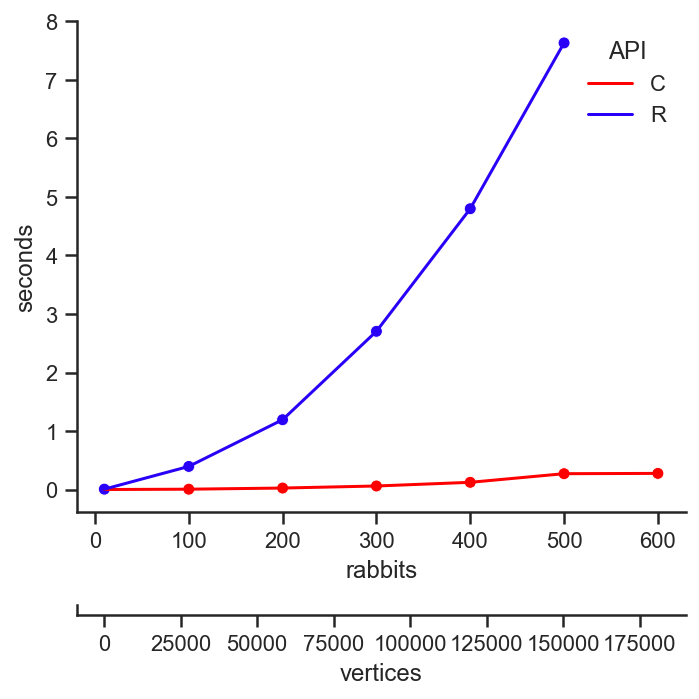

In [6]:
with sns.color_palette(['#FF0000', '#2901F7']):
    gs_kw = dict(height_ratios=[50, 1])
    fig, axes = plt.subplots(2, 1, figsize=(5, 5), gridspec_kw=gs_kw)

    construction_df.loc[construction_df.time_R > 500, 'time_R'] = np.nan
    plot_df = (construction_df.groupby(['rabbits', 'vertices'])
     .agg('mean') 
     .reset_index()
     .rename(columns={'time_c': 'C', 'time_R': 'R'})
     .melt(id_vars=['rabbits', 'vertices'], value_name='seconds', var_name='API')
    )
    sns.scatterplot(data=plot_df, x='rabbits', y='seconds', hue='API', legend=False, ax=axes[0])    
    ax = sns.lineplot(data=plot_df, x='rabbits', y='seconds', hue='API', ax=axes[0])
    leg = ax.get_legend()
    leg.get_frame().set_linewidth(0.0)
    sns.despine()
    
    ax = sns.scatterplot(data=plot_df, x='vertices', y='seconds', hue='API', legend=False, ax=axes[1], alpha=0) 
    
    axes[1].get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.savefig('construction.pdf')

In [7]:
%%R -o expectation_df
RABBIT_NUMBERS <- c(10, 20, 30, 40, 50, 60, 70, 80, 10, 100, 150, 200, 250)
expectation_df <- data.frame()

for (i in 1:9) {
    for (rabbits in RABBIT_NUMBERS) {
        graph <- construct_rabbit_graph(rabbits, 2, 4)
        
        matrix_time <- NA
        if (rabbits <= 100) {
            M <- graph_as_matrix(graph)
            start <- proc.time()[3]
            solve(M$SIM)
            end <- proc.time()[3]
            matrix_time <- end - start
        }
        
        start <- proc.time()[3]
        expectation(graph)
        end <- proc.time()[3]
        time = end-start
        expectation_df <- rbind(expectation_df, list(rabbits=rabbits, time=time, matrix_time=matrix_time,vertices=vertices_length(graph)))
    }
}

INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

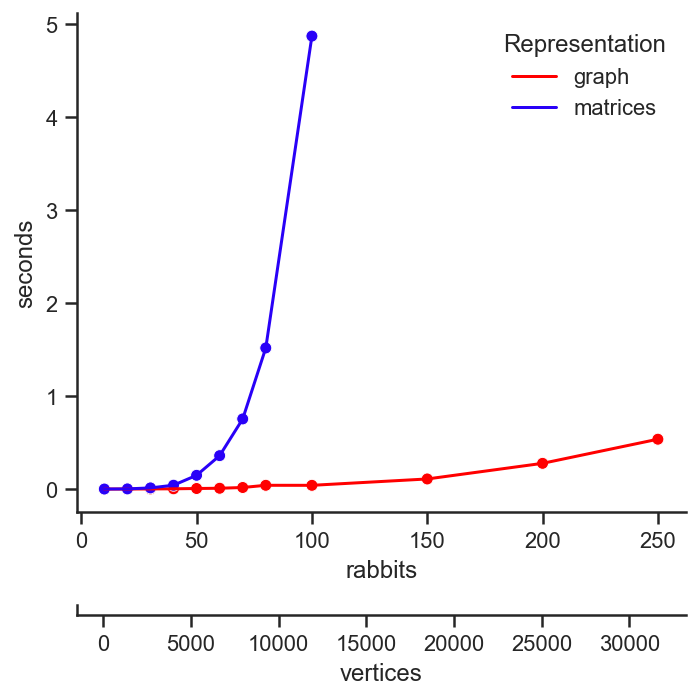

In [8]:
with sns.color_palette(['#FF0000', '#2901F7']):
    gs_kw = dict(height_ratios=[50, 1])
    fig, axes = plt.subplots(2, 1, figsize=(5, 5), gridspec_kw=gs_kw)

#    expectation_df.loc[expectation_df.matrix_time == 0, 'matrix_time'] = np.nan
    plot_df = (expectation_df.groupby(['rabbits', 'vertices'])
     .agg('mean') 
     .reset_index()
     .rename(columns={'time': 'graph', 'matrix_time': 'matrices'})
     .melt(id_vars=['rabbits', 'vertices'], value_name='seconds', var_name='Representation')
    )
    sns.scatterplot(data=plot_df, x='rabbits', y='seconds', hue='Representation', legend=False, ax=axes[0])    
    ax = sns.lineplot(data=plot_df, x='rabbits', y='seconds', hue='Representation', ax=axes[0])
    leg = ax.get_legend()
    leg.get_frame().set_linewidth(0.0)
    sns.despine()
    
    ax = sns.scatterplot(data=plot_df, x='vertices', y='seconds', hue='Representation', legend=False, ax=axes[1], alpha=0) 
    
    axes[1].get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.savefig('expectation.pdf')

In [9]:
%%R -o highermoments_df
RABBIT_NUMBERS <- c(10, 50, 100, 150, 200)
highermoments_df <- data.frame()

for (i in 1:9) {
    for (rabbits in RABBIT_NUMBERS) {
        graph <- construct_rabbit_graph(rabbits, 2, 4)

          expectation(graph)
        start <- proc.time()[3]
                      for (i in 1:100) {
        expectation(graph)
                          }
        end <- proc.time()[3]
        time = end-start
        highermoments_df <- rbind(highermoments_df, list(rabbits=rabbits, time=time,vertices=vertices_length(graph)))
    }
}

INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

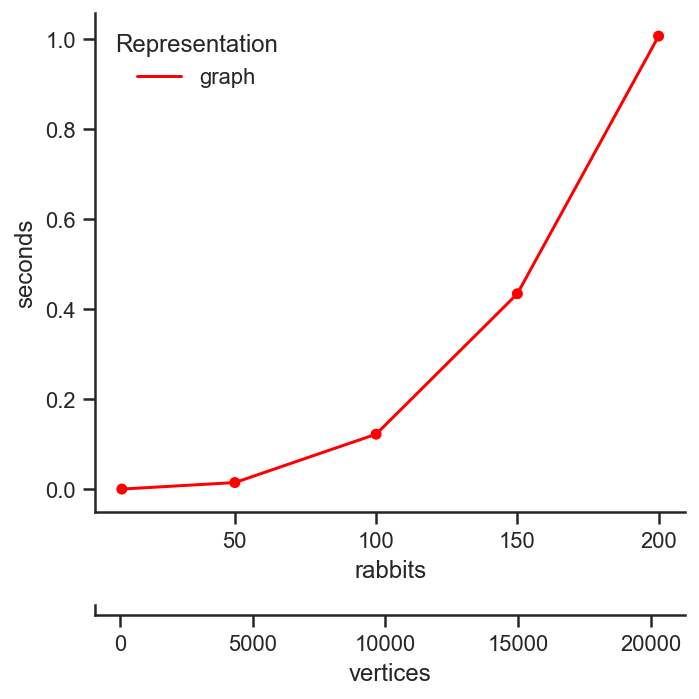

In [10]:
with sns.color_palette(['#FF0000', '#2901F7']):
    gs_kw = dict(height_ratios=[50, 1])
    fig, axes = plt.subplots(2, 1, figsize=(5, 5), gridspec_kw=gs_kw)

#    highermoments_df.loc[highermoments_df.matrix_time == 0, 'matrix_time'] = np.nan
    plot_df = (highermoments_df.groupby(['rabbits', 'vertices'])
     .agg('mean') 
     .reset_index()
     .rename(columns={'time': 'graph', 'matrix_time': 'matrices'})
     .melt(id_vars=['rabbits', 'vertices'], value_name='seconds', var_name='Representation')
    )
    sns.scatterplot(data=plot_df, x='rabbits', y='seconds', hue='Representation', legend=False, ax=axes[0])    
    ax = sns.lineplot(data=plot_df, x='rabbits', y='seconds', hue='Representation', ax=axes[0])
    leg = ax.get_legend()
    leg.get_frame().set_linewidth(0.0)
    sns.despine()
    
    ax = sns.scatterplot(data=plot_df, x='vertices', y='seconds', hue='Representation', legend=False, ax=axes[1], alpha=0) 
    
    axes[1].get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.savefig('highermoments.pdf')

In [11]:
%%R -o distcontext_df
RABBIT_NUMBERS <- c(10, 50, 100, 150, 200)
distcontext_df <- data.frame()

for (i in 1:9) {
    for (rabbits in RABBIT_NUMBERS) {
        graph <- construct_rabbit_graph(rabbits, 2, 4)

        start <- proc.time()[3]
        ctx <- distribution_context(graph, 10000)

        while (distribution_context_state(ctx)$cdf < 0.99) {
            distribution_context_step(ctx)
        }
        end <- proc.time()[3]
        time = end-start
        distcontext_df <- rbind(distcontext_df, list(rabbits=rabbits, time=time,vertices=vertices_length(graph)))
    }
}

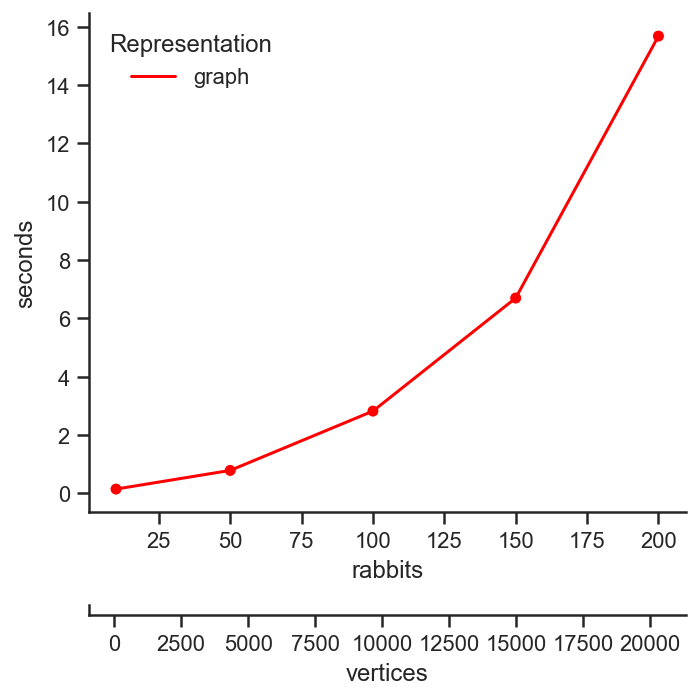

In [12]:
with sns.color_palette(['#FF0000', '#2901F7']):
    gs_kw = dict(height_ratios=[50, 1])
    fig, axes = plt.subplots(2, 1, figsize=(5, 5), gridspec_kw=gs_kw)

#    distcontext_df.loc[distcontext_df.matrix_time == 0, 'matrix_time'] = np.nan
    plot_df = (distcontext_df.groupby(['rabbits', 'vertices'])
     .agg('mean') 
     .reset_index()
     .rename(columns={'time': 'graph', 'matrix_time': 'matrices'})
     .melt(id_vars=['rabbits', 'vertices'], value_name='seconds', var_name='Representation')
    )
    sns.scatterplot(data=plot_df, x='rabbits', y='seconds', hue='Representation', legend=False, ax=axes[0])    
    ax = sns.lineplot(data=plot_df, x='rabbits', y='seconds', hue='Representation', ax=axes[0])
    leg = ax.get_legend()
    leg.get_frame().set_linewidth(0.0)
    sns.despine()
    
    ax = sns.scatterplot(data=plot_df, x='vertices', y='seconds', hue='Representation', legend=False, ax=axes[1], alpha=0) 
    
    axes[1].get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.savefig('distcontext.pdf')    